#Support Vector Machines en clasificación

En este cuaderno modelizamos el porcentaje de voto a Vox mediante el algoritmo Support Vector Machines (SVM) en clasificación. Para ello transformaremos la columna del porcentaje a este partido en otra de cinco posibles valores, con una distribución más o menos balanceada.

La estructura del cuaderno será la habitual: definición de la variable objetivo, algo no muy complicado en este caso, seguida del tratmiento a los datasets de train y test, y finalizando con la modelización como tal.

##Definición de la columna objetivo

Comenzamos con la carga de las librerías necesarias y del dataset completo de las elecciones de noviembre de 2019.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [ ]:
df_eleccion = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Nov/gen_N19_unif_cols_prov.txt', dtype = strings)

In [ ]:
df_eleccion

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019111010400101001,01,04,04001,400101001,Andalucía,Almería,Abla,1002,717,0.715569,7,710,3,707,193,310,47,30,0,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,...,73.0,80.0,89.0,81.0,94.0,87.0,91.0,77.0,72.0,42.0,67.0,56.0,19.0,4.0,0.0,1249.0,635.0,614.0,0.269816,0.590072,0.140112,304.0,0.223684,0.243395,140.0,0.421429,0.550000,0.315315,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 193, 'PSOE': 310, 'Cs': 47, 'UP': 30, '...","[('PSOE', 310), ('PP', 193), ('VOX', 122), ('C..."
1,022019111010400201001,01,04,04002,400201001,Andalucía,Almería,Abrucena,1013,711,0.701876,12,699,1,698,111,349,45,42,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,...,60.0,75.0,70.0,70.0,108.0,101.0,99.0,86.0,61.0,64.0,61.0,46.0,14.0,2.0,1.0,1202.0,637.0,565.0,0.278702,0.609817,0.111481,298.0,0.251678,0.247920,179.0,0.379888,0.625698,0.375262,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 111, 'PSOE': 349, 'Cs': 45, 'UP': 42, '...","[('PSOE', 349), ('VOX', 147), ('PP', 111), ('C..."
2,022019111010400301001,01,04,04003,400301001,Andalucía,Almería,Adra,667,484,0.725637,7,477,5,472,176,128,15,34,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,...,54.0,54.0,54.0,61.0,82.0,75.0,67.0,48.0,37.0,40.0,26.0,15.0,3.0,1.0,0.0,892.0,435.0,457.0,0.190583,0.643498,0.165919,7968.0,0.382530,8.932735,2525.0,0.432871,0.473663,0.240637,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 176, 'PSOE': 128, 'Cs': 15, 'UP': 34, '...","[('PP', 176), ('PSOE', 128), ('VOX', 116), ('U..."
3,022019111010400301002,01,04,04003,400301002,Andalucía,Almería,Adra,1306,909,0.696018,3,906,5,901,251,220,51,58,0,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,...,108.0,158.0,162.0,150.0,140.0,119.0,103.0,67.0,49.0,37.0,30.0,14.0,7.0,1.0,0.0,1752.0,865.0,887.0,0.117009,0.647260,0.235731,7968.0,0.382530,4.547945,2525.0,0.432871,0.473663,0.240637,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 251, 'PSOE': 220, 'Cs': 51, 'UP': 58, '...","[('VOX', 312), ('PP', 251), ('PSOE', 220), ('U..."
4,022019111010400301003,01,04,04003,400301003,Andalucía,Almería,Adra,1551,975,0.628627,12,963,9,954,292,202,73,52,0,327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,...,189.0,178.0,215.0,227.0,164.0,110.0,96.0,61.0,58.0,41.0,40.0,27.0,4.0,4.0,0.0,2240.0,1094.0,1146.0,0.104911,0.647768,0.247321,7968.0,0.382530,3.557143,2525.0,0.432871,0.473663,0.240637,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 292, 'PSOE': 202, 'Cs': 73, 'UP': 52, '...","[('VOX', 327), ('PP', 292), ('PSOE', 202), ('C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36297,022019111195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1638,1021,0.623321,3,1018,11,1007,303,140,30,28,0,158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,348,...,181.0,185.0,171.0,164.0,165.0,180.0,155.0,97.0,38.0,34.0,19.0,16.0,4.0,3.0,0.0,2480.0,1244.0,1236.0,0.085081

In [ ]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

In [ ]:
df_eleccion['% Vox'].describe()

count    36299.000000
mean         0.149372
std          0.080258
min          0.000000
25%          0.088054
50%          0.149819
75%          0.201411
max          0.666667
Name: % Vox, dtype: float64

In [ ]:
df_eleccion['% Vox'].isna().sum()

3

In [ ]:
df_eleccion.loc[df_eleccion['% Vox'].isna()]

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
4686,022019111014100701002,01,41,41007,4100701002,Andalucía,Sevilla,La Algaba,900,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,66.0,140.0,104.0,95.0,86.0,66.0,61.0,49.0,40.0,38.0,22.0,13.0,4.0,2.0,0.0,1199.0,582.0,617.0,0.140117,0.615513,0.244370,2549.0,0.296195,2.125938,2493.0,0.395909,0.500602,0.494447,8267.0,7610.0,24288.0,22082.0,6506.0,5395.0,1766.0,1867.0,355.0,330.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),..."
32884,022019111170301403031,17,03,03014,301403031,La Rioja,Alicante,Alicante / Alacant,752,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,74.0,95.0,77.0,85.0,72.0,74.0,82.0,80.0,39.0,39.0,28.0,12.0,8.0,3.0,0.0,1086.0,542.0,544.0,0.192449,0.616943,0.190608,183456.0,0.107573,168.928177,34757.0,0.439336,0.549040,0.159280,7944.0,7806.0,20487.0,19290.0,5159.0,4807.0,2898.0,2825.0,316.0,385.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),..."
32968,022019111170301406007,17,03,03014,301406007,La Rioja,Alicante,Alicante / Alacant,709,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,75.0,87.0,85.0,89.0,75.0,90.0,39.0,39.0,50.0,41.0,38.0,21.0,8.0,1.0,0.0,1093.0,511.0,582.0,0.181153,0.618481,0.200366,183456.0,0.107573,167.846295,34757.0,0.439336,0.549040,0.159280,7592.0,6880.0,18941.0,16729.0,5222.0,4137.0,2256.0,2468.0,385.0,382.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),..."


Podemos ver la distribución del voto a Vox, así como a PP y PSOE según las secciones españolas. Lo que más desaca es quizás la gran cantidad de éstas con un porcentaje pequeño.

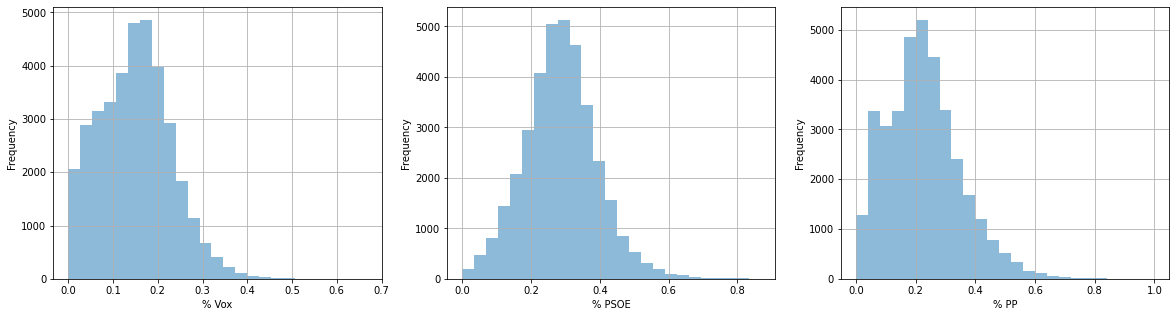

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion['% Vox'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('% Vox')

plt.subplot(1,3,2)
df_eleccion['% PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PSOE')

plt.subplot(1,3,3)
df_eleccion['% PP'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP')

plt.show()

Dividimos los valores del porcentaje a Vox en cinco bins para tener una idea de los entornos que podremos a la clasificación.

In [ ]:
pd.qcut(np.array(df_eleccion['% Vox']), 5)

[(0.169, 0.214], (0.169, 0.214], (0.214, 0.667], (0.214, 0.667], (0.214, 0.667], ..., (0.129, 0.169], (0.169, 0.214], (0.214, 0.667], (0.214, 0.667], (0.214, 0.667]]
Length: 36302
Categories (5, interval[float64]): [(-0.001, 0.0733] < (0.0733, 0.129] < (0.129, 0.169] <
                                    (0.169, 0.214] < (0.214, 0.667]]

In [ ]:
df_eleccion['VOX'].sum()

3640377

A la vista de los resultados del qcut definimos la función que hará la asignacion a cada grupo de nuestra variable a clasificar.

In [ ]:
def categoria(x):
  if x < 0.07:
    return 0

  if x < 0.13:
    return 1

  if x < 0.17:
    return 2

  if x < 0.21:
    return 3

  return 4

In [ ]:
df_eleccion['pc_VOX_cat'] = 5

Asigamos los valores de 0 a 4, y comprobamos que éstos están bastante bien balanceados.

In [ ]:
for ind in range(len(df_eleccion['pc_VOX_cat'])):

  df_eleccion['pc_VOX_cat'][ind] = categoria(df_eleccion['% Vox'][ind])


In [ ]:
df_eleccion['pc_VOX_cat'].value_counts()

1    7858
4    7845
2    7258
0    6814
3    6527
Name: pc_VOX_cat, dtype: int64

In [ ]:
df_eleccion.describe()

,cod_sec,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,0-4,...,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
count,3.630200e+04,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.000000,36302.0,36302.000000,36302.0,36302.000000,36302.0,36302.000000,36302.000000,36302.000000,36302.0,36302.000000,36302.000000,36302.0,36302.000000,36302.0,36302.000000,36302.000000,36302.000000,36302.000000,36302.0,36302.000000,36302.000000,36299.000000,36299.000000,36299.000000,36299.000000,36299.000000,36299.0,36287.000000,...,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,36287.000000,3.626000e+04,36259.000000,36245.000000,36288.000000,36288.000000,36288.000000,36259.000000,36148.000000,36148.000000,36148.00000,36148.000000,34011.000000,34011.000000,34011.000000,34011.000000,34011.000000,34011.000000,36302.000000
mean,2.566980e+09,960.600353,671.087185,0.700403,6.846537,664.240648,5.956945,658.283703,141.041045,186.003912,45.103328,85.317035,0.0,100.280343,0.0,16.385874,0.0,23.959727,14.511487,6.747066,0.0,10.398931,7.617624,0.0,3.415184,0.0,0.542697,3.294502,1.889152,0.347694,0.0,6.230538,5.197565,0.226570,0.286511,0.122317,0.149372,0.063928,0.0,56.157908,...,70.688621,78.791413,96.208808,110.559098,105.194615,100.203544,89.991402,77.103315,66.074600,59.928129,44.562626,37.282195,26.857332,11.444980,2.853363,0.448921,1295.348334,634.700141,660.648194,0.222308,0.600493,0.177199,2.213115e+05,0.229463,178.425219,28164.592234,0.423846,0.530331,0.212505,11507.366242,10871.387392,29482.09279,28025.430834,8316.651718,7309.281019,3178.457559,2941.008966,289.520129,346.385085,2.020137
std,1.437009e+09,440.833524,323.147134,0.080514,5.881103,320.238455,4.684926,317.319654,100.383408,102.784755,35.087823,57.851826,0.0,76.868296,0.0,24.478514,0.0,70.005674,48.581624,21.287632,0.0,52.928505,38.110731,0.0,20.387473,0.0,11.700270,15.415987,18.329565,3.910987,0.0,5.256721,11.194617,0.123664,0.105647,0.057102,0.080258,0.031910,0.0,45.281681,...,41.229872,49.884062,66.632152,75.284694,65.461753,55.436297,46.963765,41.712685,38.437049,36.652758,26.560850,21.209776,16.398787,8.494318,2.887779,0.832017,653.524339,326.065879,330.763307,0.095881,0.054198,0.060459,5.367535e+05,0.156315,462.526962,55914.880782,0.091696,0.097637,0.104129,3650.039798,3530.867284,10094.08316,9700.424543,3577.190859,3383.470118,1401.674911,1250.127390,119.840778,118.286029,1.418146
min,1.001010e+08,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.00000,11388.000000,1767.

In [ ]:
df_eleccion.dtypes

Sección                  object
cod_ccaa                 object
cod_prov                 object
cod_mun                  object
cod_sec                   int64
                         ...   
Renta Desempleo 2018    float64
Renta Desempleo 2015    float64
dict_res                 object
dict_res_ord             object
pc_VOX_cat                int64
Length: 98, dtype: object

##Dataset de Train

Ahora ya podemos separar el dataser completo en train y test, quedándonos con el primero.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Nov/train_set_SVM_pc_VOX.txt', index=False)
test.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Nov/test_set_SVM_pc_VOX.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Nov/train_set_SVM_pc_VOX.txt',  dtype = strings)

Dimensiones del dataset de training: (29041, 98)
Dimensiones del dataset de test: (7261, 98)


In [ ]:
df_train

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,pc_VOX_cat
0,022019111080501402001,08,05,05014,501402001,Castilla - La Mancha,Ávila,Arenas de San Pedro,525,366,0.697143,5,361,3,358,100,131,18,43,0,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,...,41.0,37.0,48.0,40.0,55.0,54.0,45.0,44.0,25.0,32.0,19.0,10.0,4.0,1.0,627.0,309.0,318.0,0.287081,0.566188,0.146730,1681.0,0.361095,2.681021,711.0,0.409283,0.623066,0.297241,9412.000000,8634.000000,19164.000000,18116.000000,4629.000000,4426.000000,3443.000000,3175.000000,347.000000,296.000000,"{'PP': 100, 'PSOE': 131, 'Cs': 18, 'UP': 43, '...","[('PSOE', 131), ('PP', 100), ('VOX', 56), ('UP...",2
1,022019111010401308001,01,04,04013,401308001,Andalucía,Almería,Almería,798,532,0.666667,3,529,2,527,97,160,41,42,0,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,...,79.0,75.0,84.0,108.0,65.0,63.0,43.0,42.0,24.0,25.0,17.0,10.0,3.0,1.0,1058.0,524.0,534.0,0.155955,0.640832,0.203214,88800.0,0.145327,83.931947,23339.0,0.433009,0.480312,0.208126,7741.000000,7309.000000,21533.000000,20201.000000,5115.000000,4098.000000,1799.000000,1804.000000,391.000000,386.000000,"{'PP': 97, 'PSOE': 160, 'Cs': 41, 'UP': 42, 'I...","[('VOX', 179), ('PSOE', 160), ('PP', 97), ('UP...",4
2,022019111033304406014,03,33,33044,3304406014,Asturias,Asturias,Oviedo,846,558,0.659574,4,554,7,547,149,194,43,72,0,71,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2,...,77.0,68.0,72.0,68.0,98.0,119.0,90.0,64.0,34.0,32.0,38.0,8.0,1.0,0.0,1022.0,476.0,546.0,0.261252,0.627202,0.111546,123956.0,0.112846,121.287671,19937.0,0.427196,0.534734,0.138554,10903.000000,10308.000000,25056.000000,24941.000000,6536.000000,6394.000000,4369.000000,3500.000000,174.000000,332.000000,"{'PP': 149, 'PSOE': 194, 'Cs': 43, 'UP': 72, '...","[('PSOE', 194), ('PP', 149), ('UP', 72), ('VOX...",1
3,022019111022206101003,02,22,22061,2206101003,Aragón,Huesca,Binéfar,1469,994,0.676651,2,992,13,979,304,295,92,100,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,19,...,150.0,170.0,153.0,145.0,137.0,120.0,118.0,110.0,85.0,77.0,57.0,37.0,14.0,0.0,2163.0,1098.0,1065.0,0.230236,0.559871,0.209894,5278.0,0.175066,2.440129,547.0,0.431444,0.418647,0.093906,11910.000000,11294.000000,32136.000000,30473.000000,8297.000000,7330.000000,3172.000000,2962.000000,170.000000,185.000000,"{'PP': 304, 'PSOE': 295, 'Cs': 92, 'UP': 100, ...","[('PP', 304), ('PSOE', 295), ('VOX', 166), ('U...",2
4,022019111084708101001,08,47,47081,4708101001,Castilla - La Mancha,Valladolid,Marzales,39,32,0.820513,0,32,0,32,8,14,2,4,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7.0,0.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,4.0,3.0,1.0,1.0,0.0,45.0,22.0,23.0,0.377778,0.555556,0.066667,4.0,0.500000,0.088889,3.0,0.333333,1.000000,0.428571,11234.267197,10618.182737,28322.021999,26938.114416,7855.336603,6845.948425,3217.875711,2985.302533,293.331625,347.217589,"{'PP': 8, 'PSOE': 14, 'Cs': 2, 'UP': 4, 'IU': ...","[('PSOE', 14), ('PP', 8), ('UP', 4), ('VOX', 4...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29036,02201911109252

Vemos que en train la variable objetivo está bien balanceada, como cabía esperar.

In [ ]:
df_train['pc_VOX_cat'].value_counts()

1    6276
4    6265
2    5775
0    5470
3    5255
Name: pc_VOX_cat, dtype: int64

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Como es habitual, nos quedamos con las columnas socioeconómicas, descartando las de los votos y porcentajes a partidos.

In [ ]:
cols_validas = ['Provincia',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'pc_VOX_cat']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
0,Ávila,525,0.697143,23.0,22.0,19.0,28.0,24.0,28.0,28.0,41.0,37.0,48.0,40.0,55.0,54.0,45.0,44.0,25.0,32.0,19.0,10.0,4.0,1.0,627.0,309.0,318.0,0.287081,0.566188,0.146730,1681.0,0.361095,2.681021,711.0,0.409283,0.623066,0.297241,9412.000000,8634.000000,19164.000000,18116.000000,4629.000000,4426.000000,3443.000000,3175.000000,347.000000,296.000000,2
1,Almería,798,0.666667,48.0,46.0,61.0,60.0,69.0,67.0,68.0,79.0,75.0,84.0,108.0,65.0,63.0,43.0,42.0,24.0,25.0,17.0,10.0,3.0,1.0,1058.0,524.0,534.0,0.155955,0.640832,0.203214,88800.0,0.145327,83.931947,23339.0,0.433009,0.480312,0.208126,7741.000000,7309.000000,21533.000000,20201.000000,5115.000000,4098.000000,1799.000000,1804.000000,391.000000,386.000000,4
2,Asturias,846,0.659574,20.0,22.0,31.0,41.0,44.0,39.0,56.0,77.0,68.0,72.0,68.0,98.0,119.0,90.0,64.0,34.0,32.0,38.0,8.0,1.0,0.0,1022.0,476.0,546.0,0.261252,0.627202,0.111546,123956.0,0.112846,121.287671,19937.0,0.427196,0.534734,0.138554,10903.000000,10308.000000,25056.000000,24941.000000,6536.000000,6394.000000,4369.000000,3500.000000,174.000000,332.000000,1
3,Huesca,1469,0.676651,97.0,115.0,127.0,115.0,115.0,100.0,121.0,150.0,170.0,153.0,145.0,137.0,120.0,118.0,110.0,85.0,77.0,57.0,37.0,14.0,0.0,2163.0,1098.0,1065.0,0.230236,0.559871,0.209894,5278.0,0.175066,2.440129,547.0,0.431444,0.418647,0.093906,11910.000000,11294.000000,32136.000000,30473.000000,8297.000000,7330.000000,3172.000000,2962.000000,170.000000,185.000000,2
4,Valladolid,39,0.820513,2.0,1.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,4.0,3.0,1.0,1.0,0.0,45.0,22.0,23.0,0.377778,0.555556,0.066667,4.0,0.500000,0.088889,3.0,0.333333,1.000000,0.428571,11234.267197,10618.182737,28322.021999,26938.114416,7855.336603,6845.948425,3217.875711,2985.302533,293.331625,347.217589,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29036,Lérida,69,0.840580,3.0,2.0,1.0,4.0,5.0,0.0,4.0,3.0,5.0,6.0,5.0,9.0,6.0,2.0,5.0,4.0,4.0,5.0,0.0,0.0,0.0,73.0,33.0,40.0,0.273973,0.589041,0.136986,15.0,0.133333,0.205479,1.0,0.000000,1.000000,0.062500,11234.267197,10618.182737,28322.021999,26938.114416,7855.336603,6845.948425,3217.875711,2985.302533,293.331625,347.217589,0
29037,Murcia,714,0.712885,27.0,54.0,44.0,40.0,41.0,56.0,46.0,66.0,77.0,70.0,60.0,65.0,45.0,40.0,58.0,36.0,40.0,22.0,6.0,1.0,0.0,894.0,437.0,457.0,0.227069,0.588367,0.184564,225048.0,0.133887,251.731544,41177.0,0.401438,0.486485,0.154670,9065.000000,8377.000000,24699.000000,22981.000000,6045.000000,5160.000000,2678.000000,2532.000000,305.000000,328.000000,4
29038,Vizcaya,1032,0.726744,90.0,114.0,93.0,90.0,41.0,42.0,55.0,117.0,150.0,161.0,106.0,81.0,58.0,53.0,51.0,43.0,30.0,20.0,9.0,1.0,0.0,1405.0,693.0,712.0,0.147331,0.577224,0.275445,1508.0,0.397215,1.073310,747.0,0.408300,0.471218,0.331264,18548.000000,18111.000000,53263.000000,51334.000000,NaN,NaN,NaN,NaN,NaN,NaN,0
29039,Tarragona,1045,0.701435,132.0,152.0,108.0,118.0,89.0,84.0,101.0,151.0,195.0,136.0,129.0,70.0,77.0,60.0,48.0,42.0,32.0,23.0,10.0,1.0,0.0,1758.0,864.0,894.0,0.122867,0.587031,0.290102,15794.0,0.142143,8.984073,2577.0,0.467598,0.513776,0.140275,10959.000000,10669.000000,31234.000000,30727.000000,9432.000000,9000.000000,2200.000000,2089.000000,277.000000,326.000000,0


In [ ]:
df_train.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
count,29041.000000,29041.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,29030.000000,2.900800e+04,29007.000000,28997.000000,29029.000000,29029.000000,29029.000000,29007.000000,28912.000000,28912.000000,28912.000000,28912.000000,27195.000000,27195.000000,27195.000000,27195.000000,27195.000000,27195.000000,29041.000000
mean,959.649186,0.700266,56.046504,64.730141,68.530899,63.912745,63.499931,70.661316,78.731691,96.039580,110.423562,105.107751,100.126490,89.960558,77.071202,66.050431,59.808440,44.441922,37.161557,26.792215,11.401963,2.836927,0.448157,1293.783982,633.996314,659.787668,0.222231,0.600701,0.177068,2.209998e+05,0.229647,178.681393,28198.933239,0.424132,0.530369,0.212671,11512.296993,10878.345017,29498.748134,28046.136783,8320.870643,7317.604326,3177.373580,2940.869905,289.589405,346.347816,2.019593
std,440.799030,0.080533,45.158344,50.100412,49.618023,42.200634,37.626543,41.335792,49.956264,66.524773,75.214347,65.524194,55.362458,46.905972,41.455802,37.655087,35.332134,25.936865,21.078730,16.407716,8.481388,2.876924,0.830029,652.311310,325.454999,330.180093,0.096022,0.054353,0.060507,5.366254e+05,0.156564,463.825659,55946.507275,0.091900,0.098029,0.104361,3646.503407,3528.716515,10095.622141,9710.568115,3571.934600,3386.928353,1401.044863,1251.278502,119.613680,117.984770,1.418831
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,0.000000
25%,692.000000,0.655212,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,432.000000,463.000000,0.159159,0.572993,0.143471,1.832000e+03,0.121005,1.310112,587.000000,0.394885,0.493930,0.137769,9103.000000,8515.750000,23256.750000,21955.000000,5971.000000,5057.500000,2212.000000,2073.000000,216.000000,274.000000,1.000000
50%,953.000000,0.706897,47.000000,54.000000,59.000000,58.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1260.000000,610.000000,649.000000,0.211544,0.605957,0.176975,1.426500e+04,0.177629,9.818093,4382.000000,0.417354,0.528010,0.196682,10941.000000,10307.000000,27610.000000,26194.500000,7747.000000,6773.000000,2996.000000,2784.000000,269.000000,335.000000,2.000000
75%,1245.000000,0.754367,73.000000,86.000000,93.000000,87.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272727,0.634060,0.212176,1.024500e+05,0.283868,82.978349,22296.00000

Ahora procedemos a rellenar los registros que son nan, con la media de sus columnas respectivas.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
count,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,2.904100e+04,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000
mean,959.649186,0.700266,56.046504,64.730141,68.530899,63.912745,63.499931,70.661316,78.731691,96.039580,110.423562,105.107751,100.126490,89.960558,77.071202,66.050431,59.808440,44.441922,37.161557,26.792215,11.401963,2.836927,0.448157,1293.783982,633.996314,659.787668,0.222231,0.600701,0.177068,2.209998e+05,0.229647,178.681393,28198.933239,0.424132,0.530369,0.212671,11512.296993,10878.345017,29498.748134,28046.136783,8320.870643,7317.604326,3177.373580,2940.869905,289.589405,346.347816,2.019593
std,440.799030,0.080533,45.149790,50.090923,49.608625,42.192641,37.619416,41.327962,49.946802,66.512172,75.200100,65.511783,55.351972,46.897087,41.447950,37.647954,35.325442,25.931953,21.074738,16.404608,8.479782,2.876379,0.829872,652.187754,325.393354,330.117553,0.096004,0.054343,0.060496,5.363204e+05,0.156473,463.474142,55934.946885,0.091881,0.098009,0.104300,3638.395237,3520.870250,10073.174056,9688.976216,3456.541211,3277.511696,1355.783308,1210.855235,115.749491,114.173205,1.418831
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,0.000000
25%,692.000000,0.655212,29.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,432.000000,463.000000,0.159178,0.573003,0.143475,1.834000e+03,0.121005,1.316274,587.000000,0.394885,0.493955,0.137769,9112.000000,8526.000000,23271.000000,21978.000000,6095.000000,5179.000000,2268.000000,2121.000000,220.000000,279.000000,1.000000
50%,953.000000,0.706897,47.000000,54.000000,59.000000,58.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1261.000000,610.000000,650.000000,0.211590,0.605948,0.176991,1.437500e+04,0.177867,9.880696,4382.000000,0.417354,0.528010,0.197366,10961.000000,10323.000000,27652.000000,26241.000000,7855.336603,6845.948425,3111.000000,2893.000000,276.000000,343.000000,2.000000
75%,1245.000000,0.754367,73.000000,86.000000,93.000000,87.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272727,0.634056,0.212171,1.024500e+05,0.283868,83.634963,22296.00000

Tomamos la columna categórica y aplicamos el algoritmo mean para pasarla a numérica.

In [ ]:
categorical = ['Provincia']

In [ ]:
df_train['Provincia'].value_counts().sum()

29041

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['pc_VOX_cat'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'Provincia': Provincia
 Albacete                  3.088235
 Alicante                  2.879592
 Almería                   3.583554
 Asturias                  2.168639
 Badajoz                   2.376392
 Barcelona                 0.416058
 Burgos                    1.938429
 Cantabria                 1.950954
 Castellón                 2.735695
 Ceuta                     3.500000
 Ciudad Real               3.168675
 Cuenca                    2.469298
 Cáceres                   2.175953
 Cádiz                     3.113158
 Córdoba                   2.699387
 Gerona                    0.287703
 Gipúzcoa                  0.004598
 Granada                   3.155722
 Guadalajara               2.795666
 Huelva                    2.916667
 Huesca                    1.889868
 Islas Baleares            2.489484
 Jaén                      2.980198
 La Coruña                 0.697013
 La Rioja                  1.151515
 Las Palmas                1.635274
 León                      2.105556
 Lug

In [ ]:
df_train.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_train.describe()

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
count,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,2.904100e+04,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000
mean,2.019593,959.649186,0.700266,56.046504,64.730141,68.530899,63.912745,63.499931,70.661316,78.731691,96.039580,110.423562,105.107751,100.126490,89.960558,77.071202,66.050431,59.808440,44.441922,37.161557,26.792215,11.401963,2.836927,0.448157,1293.783982,633.996314,659.787668,0.222231,0.600701,0.177068,2.209998e+05,0.229647,178.681393,28198.933239,0.424132,0.530369,0.212671,11512.296993,10878.345017,29498.748134,28046.136783,8320.870643,7317.604326,3177.373580,2940.869905,289.589405,346.347816,2.019593
std,1.089282,440.799030,0.080533,45.149790,50.090923,49.608625,42.192641,37.619416,41.327962,49.946802,66.512172,75.200100,65.511783,55.351972,46.897087,41.447950,37.647954,35.325442,25.931953,21.074738,16.404608,8.479782,2.876379,0.829872,652.187754,325.393354,330.117553,0.096004,0.054343,0.060496,5.363204e+05,0.156473,463.474142,55934.946885,0.091881,0.098009,0.104300,3638.395237,3520.870250,10073.174056,9688.976216,3456.541211,3277.511696,1355.783308,1210.855235,115.749491,114.173205,1.418831
min,0.004598,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,0.000000
25%,0.697013,692.000000,0.655212,29.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,432.000000,463.000000,0.159178,0.573003,0.143475,1.834000e+03,0.121005,1.316274,587.000000,0.394885,0.493955,0.137769,9112.000000,8526.000000,23271.000000,21978.000000,6095.000000,5179.000000,2268.000000,2121.000000,220.000000,279.000000,1.000000
50%,2.489484,953.000000,0.706897,47.000000,54.000000,59.000000,58.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1261.000000,610.000000,650.000000,0.211590,0.605948,0.176991,1.437500e+04,0.177867,9.880696,4382.000000,0.417354,0.528010,0.197366,10961.000000,10323.000000,27652.000000,26241.000000,7855.336603,6845.948425,3111.000000,2893.000000,276.000000,343.000000,2.000000
75%,2.699387,1245.000000,0.754367,73.000000,86.000000,93.000000,87.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.

Ahora toca el ver las correlaciones entre columnas, que vemos es muy intensa entre los sexos, edades y rentas, pero también entre provincias y la variable objetivo.

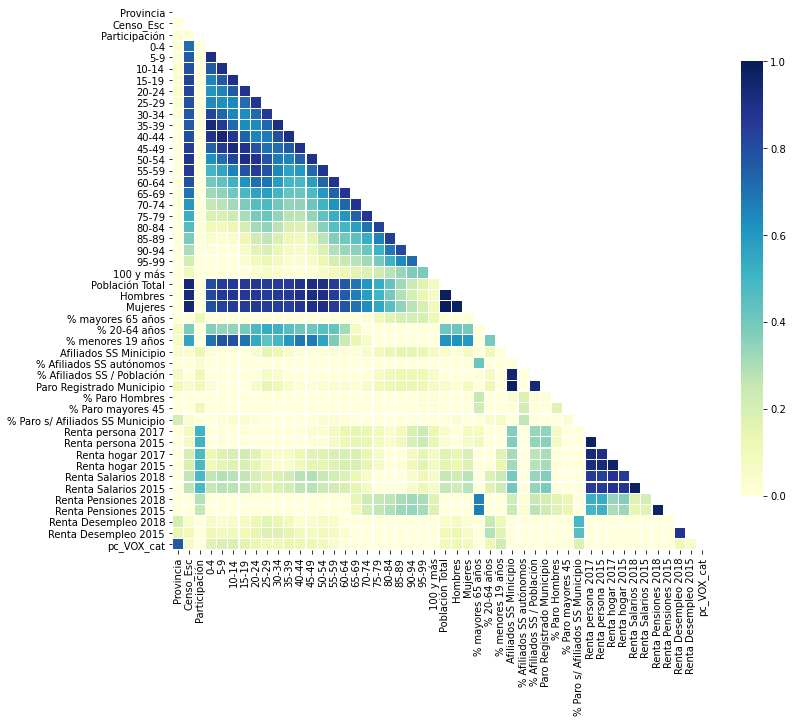

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [ ]:
df_train.columns

Index(['Provincia', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94',
       '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'pc_VOX_cat'],
      dtype='object')

Eliminamos algunas columnas que hemos visto que están demasiado correlacionadas con otras que dejamos en el dataset.

In [ ]:
df_train = df_train.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,pc_VOX_cat
0,2.430279,525,0.697143,23.0,22.0,19.0,28.0,24.0,28.0,28.0,41.0,37.0,48.0,40.0,55.0,54.0,45.0,44.0,25.0,32.0,19.0,10.0,4.0,1.0,627.0,0.287081,0.566188,0.146730,1681.0,0.361095,2.681021,711.0,0.409283,0.623066,0.297241,9412.000000,19164.000000,4629.000000,3443.000000,347.000000,2
1,3.583554,798,0.666667,48.0,46.0,61.0,60.0,69.0,67.0,68.0,79.0,75.0,84.0,108.0,65.0,63.0,43.0,42.0,24.0,25.0,17.0,10.0,3.0,1.0,1058.0,0.155955,0.640832,0.203214,88800.0,0.145327,83.931947,23339.0,0.433009,0.480312,0.208126,7741.000000,21533.000000,5115.000000,1799.000000,391.000000,4
2,2.168639,846,0.659574,20.0,22.0,31.0,41.0,44.0,39.0,56.0,77.0,68.0,72.0,68.0,98.0,119.0,90.0,64.0,34.0,32.0,38.0,8.0,1.0,0.0,1022.0,0.261252,0.627202,0.111546,123956.0,0.112846,121.287671,19937.0,0.427196,0.534734,0.138554,10903.000000,25056.000000,6536.000000,4369.000000,174.000000,1
3,1.889868,1469,0.676651,97.0,115.0,127.0,115.0,115.0,100.0,121.0,150.0,170.0,153.0,145.0,137.0,120.0,118.0,110.0,85.0,77.0,57.0,37.0,14.0,0.0,2163.0,0.230236,0.559871,0.209894,5278.0,0.175066,2.440129,547.0,0.431444,0.418647,0.093906,11910.000000,32136.000000,8297.000000,3172.000000,170.000000,2
4,2.575758,39,0.820513,2.0,1.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,4.0,3.0,1.0,1.0,0.0,45.0,0.377778,0.555556,0.066667,4.0,0.500000,0.088889,3.0,0.333333,1.000000,0.428571,11234.267197,28322.021999,7855.336603,3217.875711,293.331625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29036,0.124183,69,0.840580,3.0,2.0,1.0,4.0,5.0,0.0,4.0,3.0,5.0,6.0,5.0,9.0,6.0,2.0,5.0,4.0,4.0,5.0,0.0,0.0,0.0,73.0,0.273973,0.589041,0.136986,15.0,0.133333,0.205479,1.0,0.000000,1.000000,0.062500,11234.267197,28322.021999,7855.336603,3217.875711,293.331625,0
29037,3.836649,714,0.712885,27.0,54.0,44.0,40.0,41.0,56.0,46.0,66.0,77.0,70.0,60.0,65.0,45.0,40.0,58.0,36.0,40.0,22.0,6.0,1.0,0.0,894.0,0.227069,0.588367,0.184564,225048.0,0.133887,251.731544,41177.0,0.401438,0.486485,0.154670,9065.000000,24699.000000,6045.000000,2678.000000,305.000000,4
29038,0.011905,1032,0.726744,90.0,114.0,93.0,90.0,41.0,42.0,55.0,117.0,150.0,161.0,106.0,81.0,58.0,53.0,51.0,43.0,30.0,20.0,9.0,1.0,0.0,1405.0,0.147331,0.577224,0.275445,1508.0,0.397215,1.073310,747.0,0.408300,0.471218,0.331264,18548.000000,53263.000000,8320.870643,3177.373580,289.589405,0
29039,0.672897,1045,0.701435,132.0,152.0,108.0,118.0,89.0,84.0,101.0,151.0,195.0,136.0,129.0,70.0,77.0,60.0,48.0,42.0,32.0,23.0,10.0,1.0,0.0,1758.0,0.122867,0.587031,0.290102,15794.0,0.142143,8.984073,2577.0,0.467598,0.513776,0.140275,10959.000000,31234.000000,9432.000000,2200.000000,277.000000,0


Finalmente eliminamos los registros con valores nan en la variable objetivo, que si acaso son muy pocos de todas formas.

In [ ]:
df_train = df_train[df_train['pc_VOX_cat'].notnull()]

In [ ]:
df_train.describe()

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,pc_VOX_cat
count,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,2.904100e+04,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000,29041.000000
mean,2.019593,959.649186,0.700266,56.046504,64.730141,68.530899,63.912745,63.499931,70.661316,78.731691,96.039580,110.423562,105.107751,100.126490,89.960558,77.071202,66.050431,59.808440,44.441922,37.161557,26.792215,11.401963,2.836927,0.448157,1293.783982,0.222231,0.600701,0.177068,2.209998e+05,0.229647,178.681393,28198.933239,0.424132,0.530369,0.212671,11512.296993,29498.748134,8320.870643,3177.373580,289.589405,2.019593
std,1.089282,440.799030,0.080533,45.149790,50.090923,49.608625,42.192641,37.619416,41.327962,49.946802,66.512172,75.200100,65.511783,55.351972,46.897087,41.447950,37.647954,35.325442,25.931953,21.074738,16.404608,8.479782,2.876379,0.829872,652.187754,0.096004,0.054343,0.060496,5.363204e+05,0.156473,463.474142,55934.946885,0.091881,0.098009,0.104300,3638.395237,10073.174056,3456.541211,1355.783308,115.749491,1.418831
min,0.004598,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.142857,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3431.000000,12087.000000,1767.000000,345.000000,71.000000,0.000000
25%,0.697013,692.000000,0.655212,29.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,0.159178,0.573003,0.143475,1.834000e+03,0.121005,1.316274,587.000000,0.394885,0.493955,0.137769,9112.000000,23271.000000,6095.000000,2268.000000,220.000000,1.000000
50%,2.489484,953.000000,0.706897,47.000000,54.000000,59.000000,58.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1261.000000,0.211590,0.605948,0.176991,1.437500e+04,0.177867,9.880696,4382.000000,0.417354,0.528010,0.197366,10961.000000,27652.000000,7855.336603,3111.000000,276.000000,2.000000
75%,2.699387,1245.000000,0.754367,73.000000,86.000000,93.000000,87.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,0.272727,0.634056,0.212171,1.024500e+05,0.283868,83.634963,22296.000000,0.438402,0.550396,0.275713,12943.000000,32904.000000,9596.000000,3809.000000,322.000000,3.000000
max,3.836649,3848.000000,1.000000,650.000000,545.000000,468.000000,443.000000,436.000000,823.000000,778.000000,854.000000,918.000000,704.000000,675.000000,727.000000,863.000000,1040.000000,1161.000000,787.000000,356.000000,193.000000,145.000000,45.000000,20.000000,9902.000000,0.857143,1.000000,0.455266,2.068367e+06,1.000000,3511.658744,219132.000000,1.000000,1.000000,0.750000,30210.000000,86006.000000,26674.000000,8302.000000,846.000000,4.000000


Ahora solo nos queda definir el vector 'y' y la matriz X para el dataset de train.

In [ ]:
y_train = df_train['pc_VOX_cat']

In [ ]:
y_train

0        2
1        4
2        1
3        2
4        1
        ..
29036    0
29037    4
29038    0
29039    0
29040    2
Name: pc_VOX_cat, Length: 29041, dtype: int64

In [ ]:
X_train = df_train.drop(['pc_VOX_cat'], axis = 1)

In [ ]:
X_train.shape

(29041, 40)

In [ ]:
y_train.shape

(29041,)

##Dataset de Test

Vamos ahora con el dataset de test, al que aplicaremos los mismo procedimientos y en el mismo order que al de train.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Nov/test_set_SVM_pc_VOX.txt',  dtype = strings)

In [ ]:
df_test

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,pc_VOX_cat
0,022019111014105901016,01,41,41059,4105901016,Andalucía,Sevilla,Mairena del Aljarafe,1295,1033,0.797683,8,1025,9,1016,349,164,116,100,0,248,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,...,82.0,87.0,131.0,123.0,129.0,151.0,125.0,93.0,46.0,20.0,10.0,3.0,2.0,1.0,1631.0,801.0,830.0,0.183936,0.611895,0.204169,17655.0,0.156216,10.824647,4788.0,0.395363,0.503968,0.213340,21218.000000,18276.000000,71950.000000,62455.000000,16064.000000,14870.000000,4477.000000,4301.000000,282.000000,190.000000,"{'PP': 349, 'PSOE': 164, 'Cs': 116, 'UP': 100,...","[('PP', 349), ('VOX', 248), ('PSOE', 164), ('C...",4
1,022019111122807403019,12,28,28074,2807403019,Galicia,Madrid,Leganés,1237,1047,0.846403,5,1042,9,1033,200,308,126,170,0,143,0,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,...,48.0,65.0,116.0,187.0,201.0,130.0,91.0,46.0,14.0,10.0,4.0,2.0,0.0,0.0,1513.0,743.0,770.0,0.110377,0.695307,0.194316,56407.0,0.155371,37.281560,14852.0,0.405131,0.498721,0.208423,16704.000000,16291.000000,54014.000000,52868.000000,16367.000000,14940.000000,2710.000000,1919.000000,249.000000,261.000000,"{'PP': 200, 'PSOE': 308, 'Cs': 126, 'UP': 170,...","[('PSOE', 308), ('PP', 200), ('UP', 170), ('VO...",2
2,022019111025025204001,02,50,50252,5025204001,Aragón,Zaragoza,Tauste,1367,884,0.646672,7,877,14,863,258,290,58,54,0,178,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,...,132.0,155.0,136.0,142.0,149.0,145.0,96.0,92.0,67.0,71.0,61.0,32.0,10.0,0.0,1947.0,974.0,973.0,0.220339,0.594761,0.184900,3332.0,0.255402,1.711351,389.0,0.370180,0.480720,0.104542,10291.000000,9920.000000,26516.000000,25741.000000,7442.000000,5809.000000,2578.000000,2472.000000,186.000000,246.000000,"{'PP': 258, 'PSOE': 290, 'Cs': 58, 'UP': 54, '...","[('PSOE', 290), ('PP', 258), ('VOX', 178), ('C...",3
3,022019111090818703013,09,08,08187,818703013,Cataluña,Barcelona,Sabadell,805,560,0.695652,4,556,6,550,35,194,53,112,0,54,0,9,0,49,17,17,0,0,0,0,0,0,0,0,0,0,0,6,4,...,93.0,93.0,79.0,71.0,77.0,82.0,62.0,70.0,42.0,42.0,31.0,6.0,2.0,1.0,1129.0,553.0,576.0,0.226749,0.582817,0.190434,74657.0,0.173969,66.126661,15589.0,0.426390,0.531464,0.172739,9927.000000,9577.000000,25674.000000,24821.000000,6247.000000,5595.000000,3420.000000,3035.000000,250.000000,375.000000,"{'PP': 35, 'PSOE': 194, 'Cs': 53, 'UP': 112, '...","[('PSOE', 194), ('UP', 112), ('VOX', 54), ('Cs...",1
4,022019111025029710083,02,50,50297,5029710083,Aragón,Zaragoza,Zaragoza,891,731,0.820426,2,729,11,718,106,230,122,101,0,96,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,9,...,39.0,106.0,186.0,158.0,76.0,61.0,30.0,24.0,16.0,9.0,7.0,3.0,1.0,0.0,1208.0,579.0,629.0,0.074503,0.624172,0.301325,297766.0,0.134317,246.495033,54244.0,0.393039,0.508185,0.154098,12474.000000,11537.000000,37825.000000,35234.000000,12457.000000,11093.000000,1710.000000,1417.000000,169.000000,216.000000,"{'PP': 106, 'PSOE': 230, 'Cs': 122, 'UP': 101,...","[('PSOE', 230), ('Cs', 122), ('PP', 106), ('UP...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
df_test['pc_VOX_cat'].value_counts()

1    1582
4    1580
2    1483
0    1344
3    1272
Name: pc_VOX_cat, dtype: int64

Comenzamos con la selección de columnas válidas...

In [ ]:
df_test = df_test[cols_validas]

...seguimos con el relleno de los registros que son nan...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,pc_VOX_cat
count,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7.261000e+03,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000,7261.000000
mean,964.404627,0.700948,56.603555,65.516191,69.029764,64.237288,63.509301,70.797850,79.030316,96.885765,111.101282,105.542097,100.511782,90.114786,77.231776,66.171283,60.406917,45.045473,37.764779,27.117817,11.617059,2.919113,0.451977,1301.606173,637.515640,664.090533,0.222616,0.599661,0.177723,2.225583e+05,0.228726,177.400343,28027.261331,0.422700,0.530178,0.211842,11487.665047,10843.587660,29415.545069,27942.698606,8299.818731,7276.072049,3182.782504,2941.563804,289.243728,346.533783,2.022311
std,440.981310,0.080442,45.759556,51.075257,49.986317,41.945996,37.004455,40.794814,49.583226,67.041836,75.547393,65.196750,55.718106,47.184284,42.715737,41.408926,41.505410,28.911542,21.714886,16.357045,8.541914,2.929275,0.839742,658.181063,328.415165,332.994971,0.095293,0.053555,0.060253,5.369675e+05,0.155225,456.915050,55784.176881,0.090864,0.096046,0.103139,3658.007630,3533.456063,10070.969856,9643.368176,3486.277987,3264.775084,1360.562470,1206.836921,116.991829,115.769128,1.415498
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,2.000000,0.007463,0.250249,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,0.000000
25%,693.000000,0.657475,29.000000,33.000000,36.000000,36.000000,39.000000,45.000000,48.000000,56.000000,63.000000,63.000000,65.000000,61.000000,51.000000,43.000000,38.000000,28.000000,23.000000,15.000000,5.000000,1.000000,0.000000,907.000000,433.000000,467.000000,0.160390,0.571819,0.144958,2.028000e+03,0.123077,1.426144,624.000000,0.393605,0.494117,0.137769,9115.000000,8518.000000,23157.000000,21769.000000,6058.000000,5116.000000,2278.000000,2136.000000,218.000000,279.000000,1.000000
50%,958.000000,0.707483,48.000000,55.000000,59.000000,57.000000,60.000000,67.000000,74.000000,86.000000,98.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,44.000000,37.000000,25.000000,10.000000,2.000000,0.000000,1271.000000,616.000000,654.000000,0.213315,0.604873,0.176991,1.393200e+04,0.177629,9.747862,4373.000000,0.416297,0.528598,0.197366,10869.000000,10252.000000,27557.000000,26037.000000,7855.336603,6845.948425,3121.000000,2906.000000,275.000000,343.000000,2.000000
75%,1253.000000,0.754395,74.000000,87.000000,93.000000,87.000000,85.000000,94.000000,103.000000,126.000000,144.000000,139.000000,131.000000,117.000000,101.000000,85.000000,79.000000,59.000000,50.000000,37.000000,16.000000,4.000000,1.000000,1694.000000,828.000000,865.000000,0.271919,0.632238,0.212560,1.024500e+05,0.283855,81.614232,21242.000000,0.436895,0.550621,0.275713,12894.000000,1226

In [ ]:
df_test.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

...después pasamos a mapear la columna categórica Provincia...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_test['Provincia'].describe()

count    7261.000000
mean        2.019512
std         1.089314
min         0.004598
25%         0.697013
50%         2.489484
75%         2.637890
max         3.836649
Name: Provincia, dtype: float64

...no olviamos eliminar las columnas demasiado correlacionadas...

In [ ]:
df_test = df_test.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test.shape

(7261, 41)

...y terminamos con la selección de las filas que tienen datos válidos en la columna objetivo.

In [ ]:
df_test = df_test[df_test['pc_VOX_cat'].notnull()]

Definimos finalmente el vector 'y' y la matriz X del daatset de test.

In [ ]:
y_test = df_test['pc_VOX_cat']

In [ ]:
X_test = df_test.drop(['pc_VOX_cat'], axis = 1)

In [ ]:
y_test.shape

(7261,)

In [ ]:
X_test.shape

(7261, 40)

In [ ]:
columnas = X_train.columns

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

#Selección de las columnas más importantes

Tras trasformar las matrices y vectores en arrays numpy, echamos un vistazo a las columnas que aportan más información, mediante la librería Mutual Info.

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
y_train

array([2, 4, 1, ..., 0, 0, 2])

In [ ]:
y_test

array([4, 2, 3, ..., 1, 0, 0])

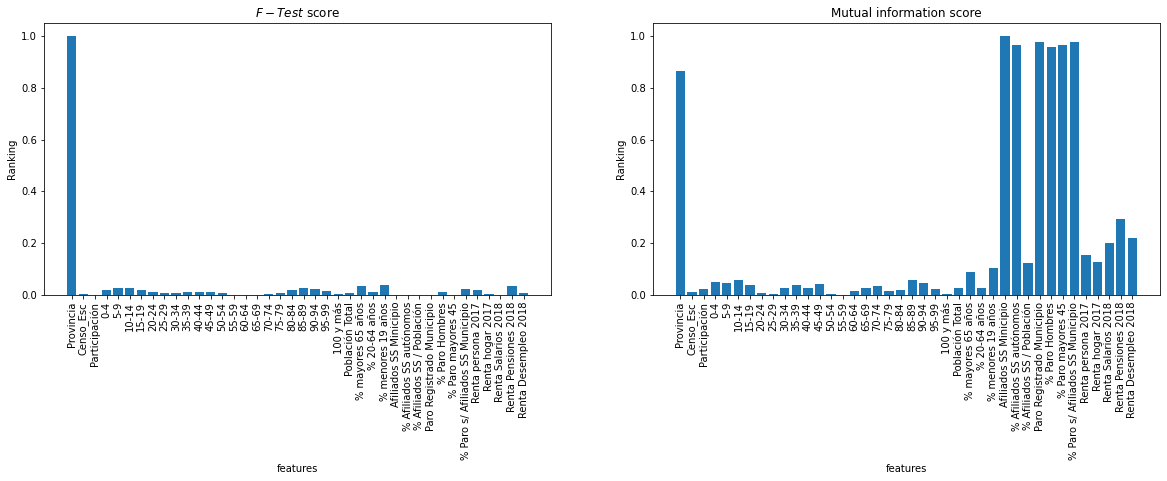

In [ ]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Encontramos que, además de la provincia, hay otras columnas importantes, tales como los porcentajes de mayores de 45 años y los afiliados a la Seguridad Social, entre otras.

Almacenamos las 10 columnas más relevantes obtenidas con MI.

In [ ]:
columnas_MI = columnas[mi > 0.2]

In [ ]:
columnas_MI

Index(['Provincia', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       'Paro Registrado Municipio', '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta Salarios 2018',
       'Renta Pensiones 2018', 'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(columnas_MI)

10

In [ ]:
X_train

array([[2.43027888e+00, 5.25000000e+02, 6.97142857e-01, ...,
        4.62900000e+03, 3.44300000e+03, 3.47000000e+02],
       [3.58355438e+00, 7.98000000e+02, 6.66666667e-01, ...,
        5.11500000e+03, 1.79900000e+03, 3.91000000e+02],
       [2.16863905e+00, 8.46000000e+02, 6.59574468e-01, ...,
        6.53600000e+03, 4.36900000e+03, 1.74000000e+02],
       ...,
       [1.19047619e-02, 1.03200000e+03, 7.26744186e-01, ...,
        8.32087064e+03, 3.17737358e+03, 2.89589405e+02],
       [6.72897196e-01, 1.04500000e+03, 7.01435407e-01, ...,
        9.43200000e+03, 2.20000000e+03, 2.77000000e+02],
       [2.91666667e+00, 1.39000000e+03, 5.97841727e-01, ...,
        5.56500000e+03, 1.96100000e+03, 5.48000000e+02]])

Nos quedamos con las columnas más importantes de cara a modelizar con SVM, y para ello reformamos las matrices X de train y test.

In [ ]:
X_train = df_train[columnas_MI].values
X_test = df_test[columnas_MI].values

In [ ]:
X_train.shape

(29041, 10)

In [ ]:
X_test.shape

(7261, 10)

##Modelización con Support Vector Machines en Clasificación

Ahora cargamos las librerías necesarias para poder modelizar con SVM en clasificación.

Además, aplicamos una normalización de los datos, imprescindible en el caso de SV Machines.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled  = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Aplicamos grid search a los hiperparámetros C y gamma...

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.01, gamma=1e-05, score=0.216, total=  58.2s
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-05, score=0.216, total=  58.0s
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-05, score=0.216, total=  58.0s
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-05, score=0.216, total=  58.3s
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.9min remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-05, score=0.216, total=  58.1s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .................. C=0.01, gamma=10.0, score=0.235, total=  59.5s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .................. C=0.01, gamma=10.0, score=0.231, total=  59.5s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .................. C=0.01, gamma=10.0, score=0.232, total=  59.6s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .................. C=0.01, gamma=10.0, score=0.233, total=  59.6s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .................. C=0.01, gamma=10.0, score=0.233, total=  59.3s
[CV] C=31.622776601683793, gamma=1e-05 ...............................
[CV] ... C=31.622776601683793, gamma=1e-05, score=0.490, total=  43.5s
[CV] C=31.622776601683793, gamma=1e-05 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 41.9min finished


best mean cross-validation score: 0.523
best parameters: {'C': 100000.0, 'gamma': 1e-05}


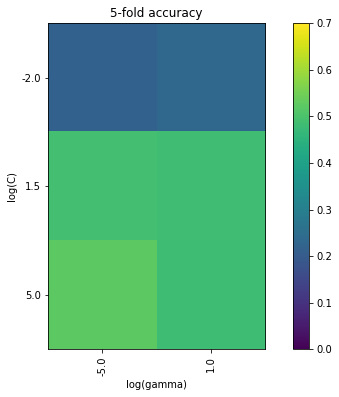

In [ ]:
# Paso 2
vectorC = np.logspace(-2, 5, 3)
vectorG = np.logspace(-5, 1, 2)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=5)
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.0, vmax=0.7)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

Y lo que encontramos es que los mejores scores se producen con un gamma de 1e-05, por lo que dejamos ya este hiperparámetro fijo, y volvemos a aplicar grid search para encontrar el mejor C. 

In [ ]:
# Paso 2
vectorC = np.logspace(1, 5, 6)
# vectorG = np.logspace(-5, 1, 2)

param_grid = {'C': vectorC}
grid = GridSearchCV(SVC(kernel='rbf', gamma = 0.0005), param_grid=param_grid, cv = 3, verbose=5)
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.0, vmax=0.7)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=10.0 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=10.0, score=0.505, total=  25.6s
[CV] C=10.0 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s


[CV] .............................. C=10.0, score=0.514, total=  25.5s
[CV] C=10.0 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.1s remaining:    0.0s


[CV] .............................. C=10.0, score=0.517, total=  25.5s
[CV] C=63.09573444801933 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] ................. C=63.09573444801933, score=0.509, total=  24.5s
[CV] C=63.09573444801933 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] ................. C=63.09573444801933, score=0.525, total=  25.0s
[CV] C=63.09573444801933 .............................................
[CV] ................. C=63.09573444801933, score=0.522, total=  24.9s
[CV] C=398.1071705534973 .............................................
[CV] ................. C=398.1071705534973, score=0.517, total=  28.3s
[CV] C=398.1071705534973 .............................................
[CV] ................. C=398.1071705534973, score=0.533, total=  27.9s
[CV] C=398.1071705534973 .............................................
[CV] ................. C=398.1071705534973, score=0.529, total=  28.0s
[CV] C=2511.886431509582 .............................................
[CV] ................. C=2511.886431509582, score=0.530, total=  38.8s
[CV] C=2511.886431509582 .............................................
[CV] ................. C=2511.886431509582, score=0.541, total=  38.0s
[CV] C=2511.886431509582 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 21.4min finished


best mean cross-validation score: 0.545
best parameters: {'C': 100000.0}


ValueError: ignored

Encontramos que el mejor C es 100000, por lo que le utilizamos para hacer el fit del modelo. El error es la representación gráfica, no en el grid search.

In [ ]:
grid.best_params_['C']

100000.0

In [ ]:
# Paso 3
Copt = grid.best_params_['C']
# Gopt = grid.best_params_['gamma']

svmModel = SVC(kernel='rbf',gamma = 0.0005, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))

Acc (TEST): 0.54


El score que obtenemos creemos que es bastante aceptable, teniendo en cuenta que el aleatorio sería de 0.2, y de hecho es similar al encontrado con otros modelos con el mismo modelo de dataset.